# INM427 Model Evaluation
## *Run this notebook to test my pre-trained MLP and SVM models*

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    precision_recall_curve,
    classification_report
)
from skorch.classifier import NeuralNetClassifier
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import random 

In [9]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

## Define MLP Architecture

In [10]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3,
                 output_size, dropout_rate=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc4(out)
        return self.sigmoid(out)

## Load Pre-Trained Models

In [11]:
try:
    best_mlp = NeuralNetClassifier(
        module=MLP,
        module__input_size=42,
        module__hidden_size1=128,
        module__hidden_size2=64,
        module__hidden_size3=32,
        module__output_size=1,
        module__dropout_rate=0.3,
        lr=0.001,
        max_epochs=40,
        optimizer__weight_decay=0.0001,
        optimizer=optim.Adam,
        criterion=nn.BCELoss,
        train_split=None
    ).initialize()

    state_dict = torch.load('best_mlp_weights.pth', map_location='cpu')
    best_mlp.module_.load_state_dict(state_dict)
    print("MLP loaded ")
    
    svm = joblib.load('best_svm.joblib')
    print("SVM loaded")
    
except Exception as e:
    print(f"Error loading models: {str(e)}")
    exit()

MLP loaded 
SVM loaded


## Loading Dataset w/preprocessing

In [12]:
try:
    df = pd.read_csv('data.csv')
    df.columns = df.columns.str.replace('[^a-zA-Z0-9]', '', regex=True)
    assert 'Bankrupt' in df.columns, "Target column 'Bankrupt' not found"
    
    # Recreating the exact same split as in my training set
    X = df.drop('Bankrupt', axis=1).astype(np.float32)
    y = df['Bankrupt'].astype(np.int32)
    
    X_train_val, X_test_proper, y_train_val, y_test_proper = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42,  
        stratify=y        
    )
    
    print(f"\nProper test set size: {len(X_test_proper)} samples")
    print(f"Class distribution: {np.bincount(y_test_proper)}")
    
    # Load preprocessing objects
    scaler = joblib.load('scaler.joblib')
    pca = joblib.load('pca.joblib')
    
    # Apply preprocessing to test set only 
    X_test_scaled = scaler.transform(X_test_proper)
    X_test_pca = pca.transform(X_test_scaled).astype('float32')
    
except Exception as e:
    print(f"Error loading/preprocessing data: {str(e)}")
    exit()


Proper test set size: 1364 samples
Class distribution: [1320   44]


## Evaluate Models


Model Evaluation on Proper Test Set

MLP Evaluation:
Optimal Threshold: 0.9845
Adjusted Threshold: 0.8368
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.42      0.64      0.51        44

    accuracy                           0.96      1364
   macro avg       0.71      0.80      0.74      1364
weighted avg       0.97      0.96      0.96      1364

ROC-AUC: 0.9107


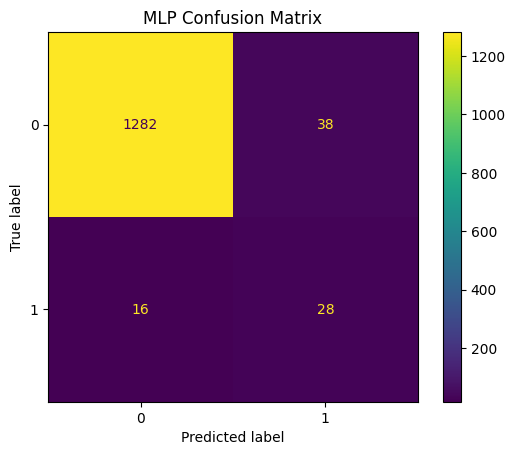


SVM Evaluation:
Optimal Threshold: 0.3224
Adjusted Threshold: 0.2740
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1320
           1       0.79      0.50      0.61        44

    accuracy                           0.98      1364
   macro avg       0.88      0.75      0.80      1364
weighted avg       0.98      0.98      0.98      1364

ROC-AUC: 0.9447


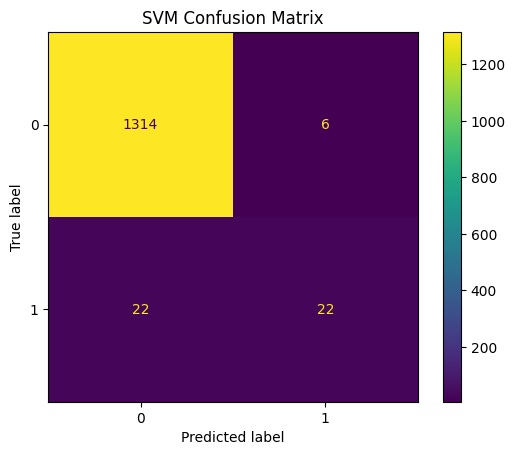

In [13]:
def evaluate_model(name, model, X, y, is_skorch=True):
    if is_skorch:
        proba = model.predict_proba(X)[:, 1]
        preds = model.predict(X)
    else:
        proba = model.predict_proba(X)[:, 1]
        preds = model.predict(X)
    
    # Threshold adjustment (same as in training)
    precision, recall, thresholds = precision_recall_curve(y, proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    adjusted_threshold = thresholds[optimal_idx] * 0.85  # 15% reduction as in training
    adjusted_preds = (proba >= adjusted_threshold).astype(int)
    
    print(f"\n{name} Evaluation:")
    print(f"Optimal Threshold: {thresholds[optimal_idx]:.4f}")
    print(f"Adjusted Threshold: {adjusted_threshold:.4f}")
    print(classification_report(y, adjusted_preds))
    print(f"ROC-AUC: {roc_auc_score(y, proba):.4f}")
    
    # Calculate and display confusion matrix
    cm = confusion_matrix(y, adjusted_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'{name} Confusion Matrix')
    plt.show()
    
    return proba, adjusted_preds

# Evaluate both models on the proper test set
print("\n" + "="*50)
print("Model Evaluation on Proper Test Set")
print("="*50)
mlp_proba, mlp_preds = evaluate_model("MLP", best_mlp, X_test_pca, y_test_proper)
svm_proba, svm_preds = evaluate_model("SVM", svm, X_test_pca, y_test_proper, is_skorch=False)


## Generate Figures (2)


Evaluation complete. Figures saved as:
- 'confusion_matrices_proper_test.png'
- 'roc_curves_proper_test.png'


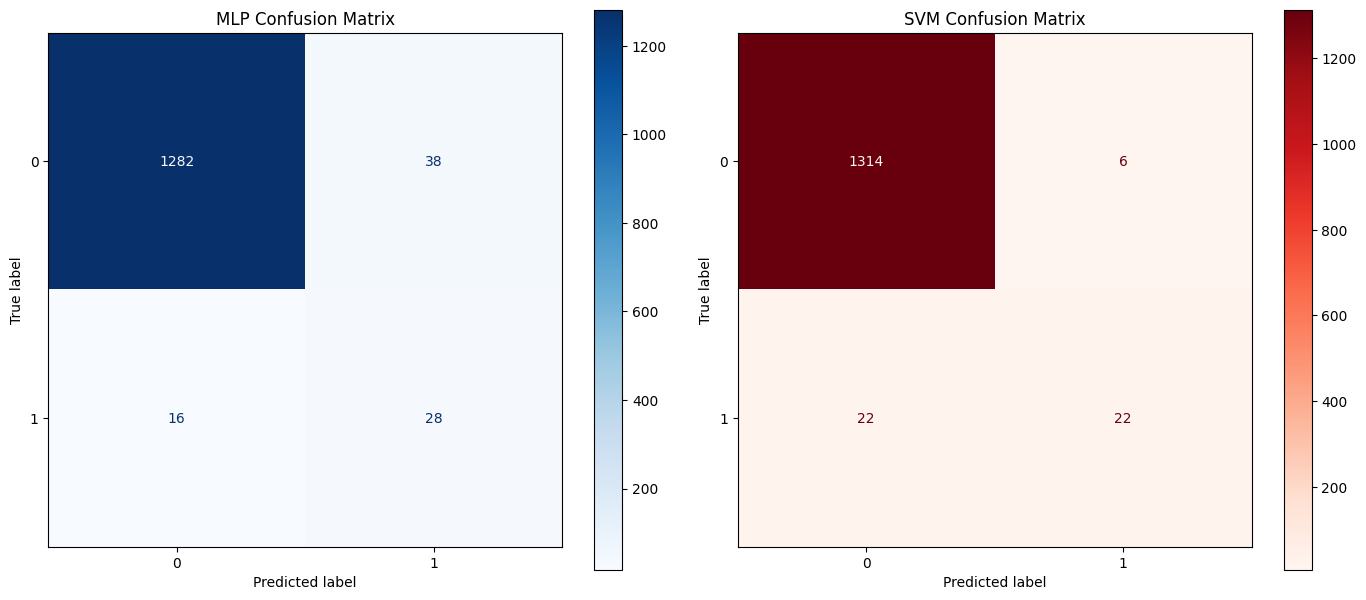

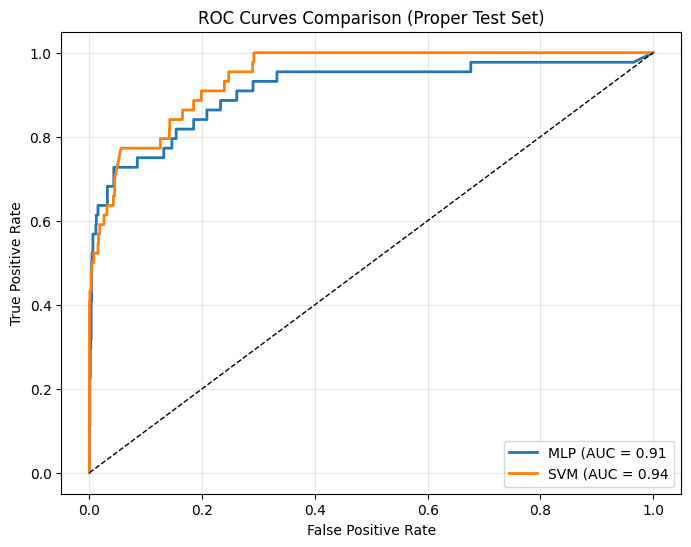

In [14]:
# Figure 1: Confusion Matrices Side by Side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ConfusionMatrixDisplay.from_predictions(y_test_proper, mlp_preds, ax=ax1, cmap='Blues')
ax1.set_title('MLP Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test_proper, svm_preds, ax=ax2, cmap='Reds')
ax2.set_title('SVM Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrices_proper_test.png', dpi=300, bbox_inches='tight')

# Figure 2: ROC Curves Comparison
plt.figure(figsize=(8, 6))
plt.grid(True, alpha=0.3)
for name, proba in [('MLP', mlp_proba), ('SVM', svm_proba)]:
    fpr, tpr, _ = roc_curve(y_test_proper, proba)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc_score(y_test_proper, proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison (Proper Test Set)')
plt.legend(loc='lower right')
plt.savefig('roc_curves_proper_test.png', dpi=300, bbox_inches='tight')

print("\nEvaluation complete. Figures saved as:")
print("- 'confusion_matrices_proper_test.png'")
print("- 'roc_curves_proper_test.png'")